In [1]:
from models import *
from utils import set_seed
from data.loaders import *
from utils.visualization import *

In [2]:
user = 'ajimenez'
path_to_model = f"/home/{user}/CoSE-pytorch/wandb/latest-run/files/weights_trained/epoch_150"

In [3]:
set_seed(0)
device = torch.device('cuda:0')
cose = CoSEModel('config.json', False)
cose.encoder.load_state_dict(torch.load(os.path.join(os.getcwd(), path_to_model,"encoder.pth"), map_location=device))
cose.decoder.load_state_dict(torch.load(os.path.join(os.getcwd(),path_to_model ,"decoder.pth"), map_location=device))
cose.position_predictive_model.load_state_dict(torch.load(os.path.join(os.getcwd(),path_to_model,"pos_pred.pth"), map_location=device))
cose.embedding_predictive_model.load_state_dict(torch.load(os.path.join(os.getcwd(),path_to_model,"emb_pred.pth"), map_location=device))

<All keys matched successfully>

In [4]:
cose.encoder = cose.encoder.eval()
cose.decoder = cose.decoder.eval()
cose.embedding_predictive_model = cose.embedding_predictive_model.eval()
cose.position_predictive_model = cose.position_predictive_model.eval()

In [5]:
val_path = f"/data/{user}/cose/test/"

In [6]:
batchdata = BatchCoSELoader(path = val_path,
                    filenames={"inputs_file" : "inputs_list_based.pkl",
                               "targets_file": "target_list_based.pkl"
                              }
                )

valid_loader = DataLoader(
                    dataset =batchdata,
                    batch_size = 1, #data is already in batch mode, batch_size = 1 means iterating every .get_next() returns a new batch
                )
stats_json = 'didi_wo_text-stats-origin_abs_pos.json'
stats_path = '/data/jcabrera/didi_wo_text/'
with open(os.path.join(stats_path, stats_json)) as json_file:
    stats = json.load(json_file)

mean_channel = stats['mean_channel'][:2]
std_channel = np.sqrt(stats['var_channel'][:2])
log_dir = f'/home/ajimenez/pruebas'

In [7]:
for batch_input, batch_target in iter(valid_loader):
    break

In [8]:
encoder_inputs = batch_input['encoder_inputs'].squeeze(dim = 0)
num_strokes = batch_input['num_strokes'].squeeze(dim = 0)
strok_len_inputs = batch_input['seq_len'].squeeze(dim = 0)
start_coord = batch_input['start_coord'].squeeze(dim = 0).squeeze()
end_coord = batch_input['end_coord'].squeeze(dim = 0).squeeze()

enc_inputs = encoder_inputs.reshape(-1, num_strokes.max(), encoder_inputs.size(1), encoder_inputs.size(2))
seq_len = strok_len_inputs.reshape(-1, num_strokes.max())
st_coord = start_coord.reshape(-1,num_strokes.max(), start_coord.size(1))

target_ink = batch_target['t_target_ink'].squeeze(dim = 0).to(device)
target_strok_len = batch_target["seq_len"].squeeze(dim = 0)

#seq_len = target_strok_len.reshape(-1, num_strokes.max())

In [9]:
i_diagram = 0

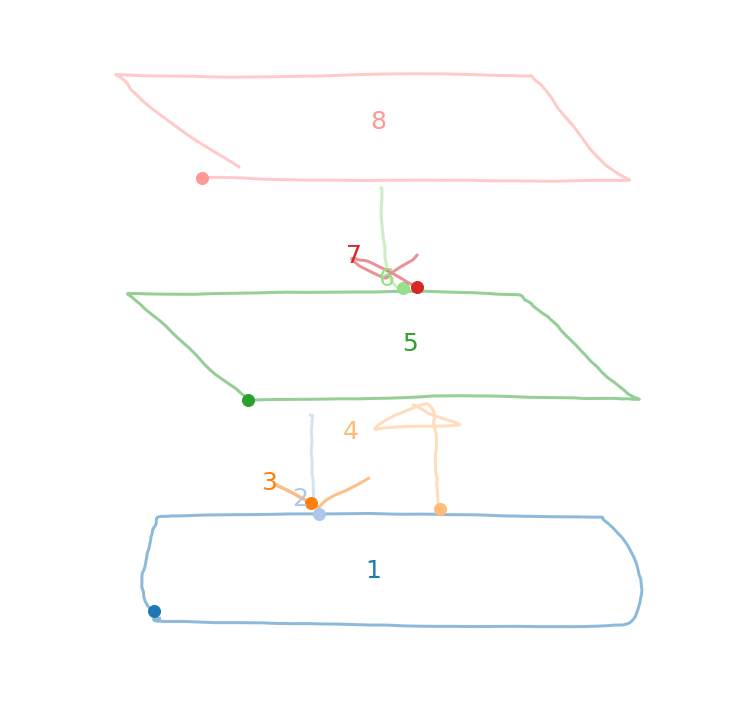

In [10]:
npfig, fig, _, _ = transform_strokes_to_image(enc_inputs[i_diagram], seq_len[i_diagram], st_coord[i_diagram], mean_channel,
                               std_channel, num_strokes=num_strokes[i_diagram], stroke_pred=None, start_coord_pred=None, output_path = log_dir, output_file = 'noutput_pruebas',  save  = True, square_figure=True, alpha=0.5, highlight_start=True)

In [11]:
encoder_inputs = encoder_inputs.to(device)
num_strokes = num_strokes.to(device)
strok_len_inputs = strok_len_inputs.to(device)
start_coord = start_coord.to(device)
end_coord = end_coord.to(device)
target_ink = target_ink.to(device)
target_strok_len = target_strok_len.to(device)

In [12]:
comb_mask, look_ahead_mask, _ = generate_3d_mask(encoder_inputs, strok_len_inputs,device, cose.config.enc_nhead)
encoder_out = cose.encoder(encoder_inputs.permute(1,0,2), strok_len_inputs, comb_mask)

### decode_sequence

In [13]:
embedding = encoder_out.detach().clone()
seq_len = target_strok_len.detach().clone()

In [14]:
def decode_sequence(decoder_model, embedding, seq_len, device):
    """Decodes an stroke into a sequence by mapping t in [0,1] to seq_len.

    Args:
      embedding (Tensor): stroke sample or dict of shape (1, latent_units).
      seq_len (np.array): # of sequence steps.

    Returns:
      decoded_seq (Tensor): decoded sequence
    """
    n_strokes = embedding.size(0)
    n_latent = embedding.size(1)
    max_len = seq_len.max().item()
    
    # reshaping embedding input
    embedding_inp = embedding.unsqueeze(1).repeat(1,max_len,1).reshape(-1, n_latent)
    
    # creating t_inputs
    t_vals = []
    for seq_index in range(len(seq_len)):
        range_t = torch.linspace(start = 0.0, end = 1.0, steps = seq_len[seq_index]) #tf.expand_dims(tf.linspace(0.0, 1.0, seq_len_tf[sid]), axis=1)
        t_ = torch.zeros(max_len,1)
        t_[:seq_len[seq_index],0] = range_t
        t_vals.append(t_)
    t_inputs = torch.cat(t_vals, axis=0)
    
    # reshaping t_inputs and concatenating
    t_inputs_reshaped = t_inputs.reshape(-1,1).to(device)
    decoder_inp = torch.cat([embedding_inp, t_inputs_reshaped], dim = 1)
    
    #pass to decoder
    
    strokes_out, ae_mu, ae_sigma, ae_pi= decoder_model(decoder_inp)
    
    #reshaping to strokes x diagram shape
    recon_stroke  = strokes_out.reshape(n_strokes, -1, strokes_out.shape[-1])
    
    return recon_stroke

In [15]:
recon_stroke = decode_sequence(cose.decoder, embedding, seq_len, cose.device)

/home/ajimenez/CoSE-pytorch/models/gmm.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out_pi = torch.nn.functional.softmax(out_pi)


In [16]:
target_stroke = batch_target['stroke'].squeeze(dim=0)

In [17]:
global_seq_len = batch_target["seq_len"].squeeze(dim=0)

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

#### TODO: Undo preprocessing function

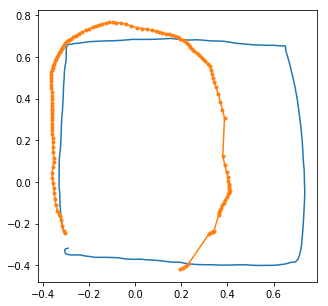

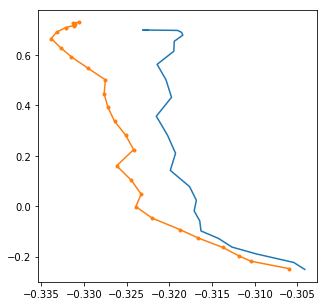

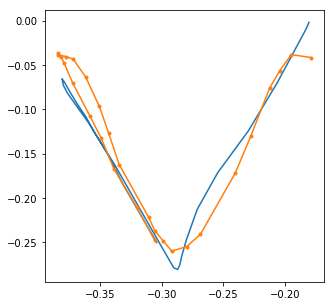

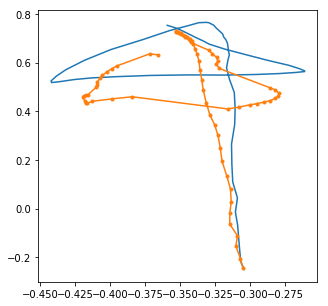

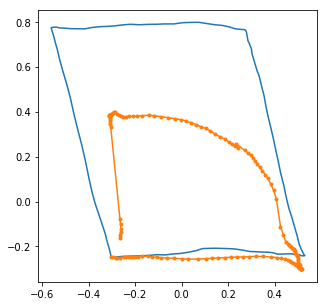

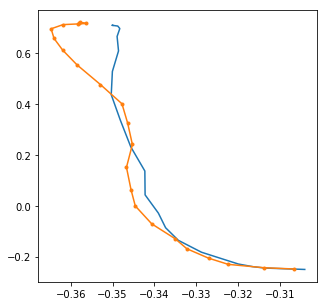

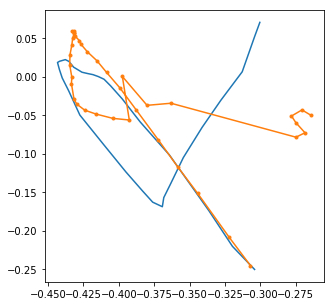

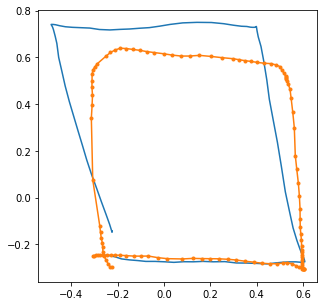

In [19]:
for i in range(recon_stroke.shape[0]):
    plt.figure(figsize = (5,5))
    plt.plot(target_stroke[i].squeeze().cpu().detach()[:seq_len[i],0], target_stroke[i].squeeze().cpu().detach()[:global_seq_len[i],1],'-')
    plt.plot(recon_stroke[i].squeeze().cpu().detach()[:seq_len[i],0], recon_stroke[i].squeeze().cpu().detach()[:global_seq_len[i],1],'.-')

### __predict_embedding_ordered_batch

In [20]:
def _predict_embedding_ordered_batch(pred_emb_model, device, embedding, start_coord, given_strokes = 2):
    '''
    Returns predictions and target for the ordered batch embedding in input
    Args:
        pred_emb_model (Model): the prediction embedding model
        device (str): the device to allocate tensors
        embedding (Tensor): the embedding from input batch
        start_coord (Tensor): the positions from input batch
        given_strokes (int): number of initial given strokes
    Outputs:
        pred_emb (Tensor): predicted embeddings
        target_emb (Tensor): target embeddings
    '''
    n_strokes = embedding.size(0)
    n_predictions = n_strokes -  given_strokes
    embedding_unsqueezed = embedding.unsqueeze(dim = 0)
    
    # create data with padding for autoregressive prediction
    inp_emb = embedding_unsqueezed.repeat(n_predictions, 1,1)[:,:-1]
    mask = (torch.triu(torch.ones(n_strokes, n_strokes-1), diagonal = 1) == 0).float()
    mask = mask[given_strokes-1:-1].to(device)
    
    # create input variables to model
    ## inputs
    inp_emb = inp_emb*mask.unsqueeze(-1).repeat(1,1, inp_emb.shape[-1])
    inp_pos = start_coord.unsqueeze(dim = 0).repeat(n_predictions,1,1)[:,:-1]
    seq_len_inputs = torch.range(given_strokes, n_strokes-1).int().to(device)
    ## targets
    target_pos = start_coord[given_strokes:]
    target_emb = embedding[given_strokes:]
    
    # create mask for TransformerModel in Predictive Embedding Model
    seq_mask_rel  = 1 - (torch.arange(seq_len_inputs.max().item()).to(cose.device)[None, :] < seq_len_inputs[:, None]).float()
    seq_mask_rel  = seq_mask_rel.masked_fill(seq_mask_rel == 1, float('-inf')).unsqueeze(dim=1).repeat(1,seq_mask_rel.shape[1],1).repeat_interleave(cose.config.rel_nhead,dim = 0)
    
    # pass to Predictive Model
    pos_model_inputs = torch.cat([inp_emb, inp_pos], dim = -1)
    emb_pred_mu, emb_pred_sigma, emb_pred_pi = cose.embedding_predictive_model(pos_model_inputs, seq_len_inputs, target_pos, src_mask  = seq_mask_rel)
    pred_emb = cose.embedding_predictive_model.draw_sample(emb_pred_mu, emb_pred_sigma, emb_pred_pi)
    
    return emb_pred_mu, emb_pred_sigma, emb_pred_pi, pred_emb, target_emb

In [21]:
given_strokes  = 2

In [22]:
emb_pred_mu, emb_pred_sigma, emb_pred_pi, pred_emb, target_emb = _predict_embedding_ordered_batch(cose.embedding_predictive_model, cose.device, embedding, start_coord, given_strokes = given_strokes)

/home/ajimenez/.local/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


In [23]:
nll_embedingg_loss = -1*gmm.logli_gmm_logsumexp(target_emb, emb_pred_mu, emb_pred_sigma, emb_pred_pi)[:,0].detach().cpu().numpy()

In [24]:
nll_embedingg_loss

array([-7.983972  ,  0.5812422 , -4.629679  , -0.40002567, -2.9649713 ,
       -4.9834766 ], dtype=float32)

#### __decode_embedding_all_components

In [35]:
def __decode_embedding_all_components(emb_pred_mu, emb_pred_sigma, emb_pred_pi, seq_len):
    emb_sample, emb_pi = cose.embedding_predictive_model.gmm.draw_sample_every_component(emb_pred_mu, emb_pred_sigma, emb_pred_pi, greedy=False)
    # reshaping
    emb_samples = emb_sample[:, 0, :, :].detach()
    emb_pis = emb_pi[:, 0, :].detach().cpu().numpy()
    n_components = emb_pis.shape[1]
    # create possible predictions for all components
    emb_samples_compwise = emb_samples.permute(1,0,2).reshape(-1, emb_samples.size(-1)) #first: first component prediction for all batches, second: second component prediction for all batches, so forth
    emb_stroke_lens = seq_len[given_strokes:].repeat(n_components) #first: stroke lenghts for all batches in first component, and so forth
    #decoding strokes
    recon_strokes_pred = decode_sequence(cose.decoder, emb_samples_compwise, emb_stroke_lens, cose.device)
    
    return recon_strokes_pred.detach()

In [36]:
recon_strokes_pred = __decode_embedding_all_components(emb_pred_mu, emb_pred_sigma, emb_pred_pi, seq_len)

In [24]:
given_strokes = 2


In [25]:
inp_emb = embedding_unsqueezed.repeat(n_predictions, 1,1)[:,:-1]
mask = (torch.triu(torch.ones(n_strokes, n_strokes-1), diagonal = 1) == 0).float()
mask = mask[given_strokes-1:-1].to(cose.device)
inp_emb = inp_emb*mask.unsqueeze(-1).repeat(1,1, inp_emb.shape[-1])

In [70]:
inp_pos = start_coord.unsqueeze(dim = 0).repeat(n_predictions,1,1)[:,:-1]

In [73]:
target_pos = start_coord[given_strokes:]
target_emb = embedding[given_strokes:]
seq_len_inputs = torch.range(given_strokes, n_strokes-1).int().to(cose.device)

/home/ajimenez/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  This is separate from the ipykernel package so we can avoid doing imports until


In [67]:
seq_mask_rel  = 1 - (torch.arange(seq_len_inputs.max().item()).to(cose.device)[None, :] < seq_len_inputs[:, None]).float()
seq_mask_rel  = seq_mask_rel.masked_fill(seq_mask_rel == 1, float('-inf')).unsqueeze(dim=1).repeat(1,seq_mask_rel.shape[1],1).repeat_interleave(cose.config.rel_nhead,dim = 0)
# Predictive model Teacher forcing

In [72]:
pos_model_inputs = torch.cat([inp_emb, inp_pos], dim = -1)

In [ ]:
#greedy =  True

In [75]:
emb_pred_mu, emb_pred_sigma, emb_pred_pi = cose.embedding_predictive_model(pos_model_inputs, seq_len_inputs, target_pos, src_mask  = seq_mask_rel)

/home/ajimenez/CoSE-pytorch/models/gmm.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out_pi = torch.nn.functional.softmax(out_pi)


In [80]:
embedding_sample = cose.embedding_predictive_model.draw_sample(emb_pred_mu, emb_pred_sigma, emb_pred_pi)

In [56]:
import tensorflow as tf

In [60]:
tf.range(given_strokes, n_strokes).shape

TensorShape([6])

/home/ajimenez/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  """Entry point for launching an IPython kernel.


tensor([2., 3., 4., 5., 6., 7.])

In [51]:
seq_mask_rel

tensor([[0., 0., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')

In [ ]:
seq_mask_rel  = seq_mask_rel.masked_fill(seq_mask_rel == 1, float('-inf')).unsqueeze(dim=1).repeat(1,seq_mask_rel.shape[1],1).repeat_interleave(cose.config.rel_nhead,dim = 0)         


In [33]:
inp_emb.shape

torch.Size([6, 7, 8])

In [32]:
seq_mask_rel

torch.Size([28, 8, 8])

/home/ajimenez/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  """Entry point for launching an IPython kernel.


In [60]:
seq_mask_rel.shape

torch.Size([7, 8])

In [ ]:
#emb_pred_mu, emb_pred_sigma, emb_pred_pi = self.embedding_predictive_model(pos_model_inputs, seq_len_inputs, tgt_cond, src_mask  = seq_mask_rel)

#### equivalent to tensorflow?

In [51]:
import tensorflow as tf

In [52]:
embedding_tf = tf.convert_to_tensor(embedding.cpu().numpy())

In [53]:
(torch.tensor(tf.reshape(tf.tile(tf.expand_dims(embedding_tf, 1), [1, max_len, 1]), (-1, n_latent)).numpy()) == embedding.unsqueeze(1).repeat(1,max_len,1).reshape(-1, n_latent).to('cpu')).all()

tensor(True)

> yes

#### creating seq_len

In [54]:
seq_len_tf = tf.convert_to_tensor(seq_len.cpu().numpy())

In [55]:
seq_len_tf

<tf.Tensor: id=7, shape=(8,), dtype=int64, numpy=array([142,  27,  28,  73, 139,  23,  38, 115])>

In [56]:
t_vals = []
for sid in range(len(seq_len_tf)):
  t_ = tf.expand_dims(tf.linspace(0.0, 1.0, seq_len_tf[sid]), axis=1)
  t_ = tf.pad(tensor=t_, paddings=[[0, max_len - seq_len_tf[sid]], [0, 0]])
  t_vals.append(t_)
t_inp_tf = tf.concat(t_vals, axis=0)

In [57]:
t_inp_tf.shape

TensorShape([1136, 1])

In [58]:
m = (torch.tensor(t_inp_tf.numpy()) == t_inputs.to('cpu'))

In [59]:
t_inputs.to('cpu').shape

torch.Size([1136, 1])

In [60]:
torch.tensor(t_inputs.numpy()).shape

torch.Size([1136, 1])

In [61]:
compare_t_inp_tf = torch.tensor(t_inp_tf.numpy())
compare_t_inp_torch = torch.tensor(t_inputs.numpy())

#### equivalent?

> yes, some floating values are infinitesimally different

In [62]:
print ("decoder_inputs", t_inp_tf)
n_t_targets = tf.shape(input=t_inp_tf)[1]
decoder_inputs = tf.reshape(t_inp_tf, [-1, 1])
print ("decoder_inputs after shape", t_inp_tf)
tiled = tf.tile(embedding_tf[:, tf.newaxis, :], [1, n_t_targets, 1])
embedding = tf.reshape(tiled, [-1, 8])

decoder_inputs tf.Tensor(
[[0.       ]
 [0.0070922]
 [0.0141844]
 ...
 [0.       ]
 [0.       ]
 [0.       ]], shape=(1136, 1), dtype=float32)
decoder_inputs after shape tf.Tensor(
[[0.       ]
 [0.0070922]
 [0.0141844]
 ...
 [0.       ]
 [0.       ]
 [0.       ]], shape=(1136, 1), dtype=float32)


In [63]:
given_strokes = 2
n_strokes = embedding_tf.numpy().shape[0]
n_predictions = n_strokes - given_strokes
embedding_tf_v2 = tf.expand_dims(embedding_tf, axis=0)
inp_emb = tf.tile(embedding_tf_v2, [n_predictions, 1, 1])[:, :-1] #porque del ultimo no tenemos target

In [64]:
inp_emb.shape

TensorShape([6, 7, 8])

In [65]:
mask_ = tf.linalg.band_part(tf.ones((n_strokes, n_strokes-1)), -1, 0)

In [66]:
mask_

<tf.Tensor: id=208, shape=(8, 7), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0., 0.],
       [1., 1., 1., 1., 0., 0., 0.],
       [1., 1., 1., 1., 1., 0., 0.],
       [1., 1., 1., 1., 1., 1., 0.],
       [1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.]], dtype=float32)>

In [51]:
mask_ = mask_[given_strokes-1:-1]

In [54]:
mask_

<tf.Tensor: id=233, shape=(6, 7), dtype=float32, numpy=
array([[1., 1., 0., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0., 0.],
       [1., 1., 1., 1., 0., 0., 0.],
       [1., 1., 1., 1., 1., 0., 0.],
       [1., 1., 1., 1., 1., 1., 0.],
       [1., 1., 1., 1., 1., 1., 1.]], dtype=float32)>

In [41]:
inp_emb *= tf.expand_dims(mask_, axis=-1)

In [42]:
inp_emb

<tf.Tensor: id=215, shape=(6, 7, 8), dtype=float32, numpy=
array([[[ 0.27557373, -0.17884265, -0.05478858, -0.6103938 ,
          0.37061447,  0.25775877,  0.00347395, -0.04380585],
        [ 0.30577847,  0.27693757, -0.60956025,  0.03927436,
          0.14399202,  0.6273867 , -0.18086372, -0.02275818],
        [ 0.        ,  0.        , -0.        , -0.        ,
          0.        , -0.        , -0.        , -0.        ],
        [ 0.        , -0.        , -0.        ,  0.        ,
          0.        ,  0.        ,  0.        , -0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        , -0.        , -0.        ],
        [ 0.        ,  0.        , -0.        ,  0.        ,
          0.        ,  0.        , -0.        , -0.        ],
        [ 0.        , -0.        , -0.        , -0.        ,
          0.        , -0.        , -0.        , -0.        ]],

       [[ 0.27557373, -0.17884265, -0.05478858, -0.6103938 ,
          0.37061

In [ ]:
start_positions = tf.tile(tf.transpose(a=input_batch[C.INP_START_COORD], perm=[1,0,2]), [n_predictions,1,1])[:, :-1]
if self.predictive_model.end_positions:
  end_positions = tf.tile(tf.transpose(a=input_batch[C.INP_END_COORD], perm=[1,0,2]), [n_predictions,1,1])[:, :-1]
  context_pos = tf.concat([start_positions, end_positions], axis=-1)
else:
  context_pos = start_positions

target_pos = input_batch[C.INP_START_COORD][given_strokes:]
target_emb = embeddings[0, given_strokes:]

In [ ]:
def decode_sequence(self, embedding, seq_len):
"""Decodes an stroke into a sequence by mapping t in [0,1] to seq_len.
Args:
  embedding: stroke sample or dict of shape (1, latent_units).
  seq_len (np.array): # of sequence steps.
Returns:
"""
if isinstance(embedding, dict):
  embedding = self.net_embedding.draw_sample(embedding)

n_strokes = tf.shape(input=embedding)[0]
n_latent = tf.shape(input=embedding)[1]
max_len = tf.reduce_max(input_tensor=seq_len)

embedding_inp = tf.reshape(
    tf.tile(tf.expand_dims(embedding, 1), [1, max_len, 1]), (-1, n_latent))
# TODO TF compatible? Only works in eager mode right now.
t_vals = []
for sid in range(len(seq_len)):
  t_ = tf.expand_dims(tf.linspace(0.0, 1.0, seq_len[sid]), axis=1)
  t_ = tf.pad(tensor=t_, paddings=[[0, max_len - seq_len[sid]], [0, 0]])
  t_vals.append(t_)
t_inp = tf.concat(t_vals, axis=0)

decoded_out = self.call_decode(embedding_inp, t_inp, training=False)
# Convert stroke batch into a diagram sample with padded strokes.
decoded_seq = self.batch_stroke_to_single_diagram(decoded_out, n_strokes)
decoded_seq["seq_len"] = seq_len
return decoded_seq

In [60]:
  def __predict_embedding_ordered_batch(self, input_batch, target_batch, embeddings, sample_idx, given_strokes=2):
    """Predict all the next embeddings in an ordered fashion for a given sample.
    
    Operates in batch mode for efficiency.
    Args:
      input_batch:
      target_batch:
      embeddings: (1, n_strokes, embedding_size)
      sample_idx:
      given_strokes: minimum # of strokes to be conditioned on.
    Returns:
      Log-likelihood of shape (n_strokes-2) and predicted embeddings of shape
      (n_strokes-2, embedding_size)
    """
    n_strokes = embeddings.numpy().shape[0]
    if n_strokes <= given_strokes:
      return list()
    
    n_predictions = n_strokes - given_strokes

    embeddings = tf.expand_dims(embeddings, axis=0)
    inp_emb = tf.tile(embeddings, [n_predictions, 1, 1])[:, :-1]
    mask_ = tf.linalg.band_part(tf.ones((n_strokes, n_strokes-1)), -1, 0)
    mask_ = mask_[given_strokes-1:-1]
    inp_emb *= tf.expand_dims(mask_, axis=-1)

    start_positions = tf.tile(tf.transpose(a=input_batch[C.INP_START_COORD], perm=[1,0,2]), [n_predictions,1,1])[:, :-1]
    if self.predictive_model.end_positions:
      end_positions = tf.tile(tf.transpose(a=input_batch[C.INP_END_COORD], perm=[1,0,2]), [n_predictions,1,1])[:, :-1]
      context_pos = tf.concat([start_positions, end_positions], axis=-1)
    else:
      context_pos = start_positions
    
    target_pos = input_batch[C.INP_START_COORD][given_strokes:]
    target_emb = embeddings[0, given_strokes:]

    out_ = self.model.predict_embedding_ar(inp_emb,
                                           inp_pos=context_pos,
                                           target_pos=target_pos,
                                           seq_len=tf.range(given_strokes, n_strokes))
    return out_, target_emb